In [208]:
import sys
import os

# Ajoutez le chemin au sys.path
sys.path.append('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python')



# Listez les fichiers dans le répertoire pour vérifier que Init_folders.py est présent
print("\nFichiers dans le répertoire src_python :")
print(os.listdir('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/src_python/'))

# Importez les modules
import numpy as np
from pathlib import Path
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import subprocess
import glob
import itertools
import seaborn as sns
import array

from Init_folders import prepare_ginette_directories, compile_ginette
import Direct_model
from Read_obs import process_obs_data
import Plot
import importlib
importlib.reload(Direct_model)
importlib.reload(Plot)
from Direct_model import setup_ginette, generate_zone_parameters, initial_conditions, boundary_conditions, run_direct_model, remove_first_two_days
from Plot import plot_obs, plot_obs_zoom, plot_compare_temperatures_obs_sim, plot_temperatures_profiles, plot_water_profiles_interpol, plot_temperature_profiles_interpol, plot_heat_flux_profiles_interpol,plot_fluxes_timeseries,plot_domain
prepare_ginette_directories('/home/ariviere/Programmes/ginette/application/2024_TD_ENS/SYNTHETIC_CASES/')


Fichiers dans le répertoire src_python :
['define_names.py', 'Plot.py', 'Read_obs.py', 'stat_critere.py', '__pycache__', 'Direct_model.py', 'Init_folders.py']
Current working directory: /home/ariviere/Programmes/ginette/application/2024_TD_ENS/SYNTHETIC_CASES
Directory 'SENSI' already exists.
Directory 'OUTPUT' already exists.


# Setting up a synthetic problem
First, let's define our modeling domain. We'll model temperature within the topmost five meters of a streambed at 251 equally-spaced grid points, for a grid spacing of 2 cm. Note that the first and last grid points are where we'll enforce Dirichlet boundary conditions on the temperature and hydraulic head, so we'll actually be computing temperatures at 249 locations. By modeling down to 5 m, we reach a depth where the temperature isn't affected significantly by daily surface temperature variations.

In [209]:
# size column meter
z_top = 0 # meters
z_bottom = 5 # meters
az=abs(z_top-z_bottom)
n_depths = 250


#discretisation : size cell in meter
dz=az/n_depths
print('dz=',dz)
dz_obs=0.1

dz= 0.02


Next, let's set up the times after initial time $t=0$ at which we'll compute temperatures. We will use a continuous-time, making the assumption of constant discharge and linearly varying boundary temperatures across each time step. Since the discharge and boundary temperatures change over time, the state space model is updated after each time step. So, the time step should be short enough that those assumptions are valid. For this problem setup, we'll use 10 minute time interval, and model 20 days worth of temperatures. The units of all time variables are seconds.

In [210]:
# 10 minute interval
dt = 10*60 # seconds
# 20 days
nb_day = 20 # days
state=1
date_simul_bg=pd.to_datetime("2022/04/21 14:00:00")

z_obs=setup_ginette(dt, state, nb_day, z_top, z_bottom, az, dz, date_simul_bg,dz_obs)


la simulation commence à 2022-04-21 14:00:00


## Physical constants

The physical constants used by `Ginette` are $\lambda$ in W/m&deg;C, and $C_s$ in $m^2$ $s^{-2}$ $C^{-1}$, as defined above.
# Intrinsic Permeability

## Intrinsic Permeability [m²]

$$
k = \frac{K \cdot \mu}{\rho \cdot g}
$$

Where:
- $ k $ = intrinsic permeability [m²]
- $ K $ = hydraulic conductivity [m/s]

## Constant Parameters

- $ \mu $ = viscosity [Pa·s]
- $ \rho $ = density [kg/m³]
- $ g $ = gravitational acceleration [m/s²], approximately \( 9.81 \)

## Calculation of Intrinsic Permeability
$$
k = 10^{\text{REF}_k}
$$



In [211]:
nb_zone=1
alt_thk=0
## Physical constants
# Porosité
REF_n = 0.8  # \omega

#-----------------------------------------------------------------
## Perméabilité intrinsèque [m2]  k=K*mu/(rho*g)
## K Conductivité hydraulique [m.s-1]
## Paramètres constants
### mu Viscosité [Pa.s]
### rho Densité [kg.m-3]
### g Gravité  9.81 [m2.s-1]

# k=10**REF_k
REF_k = -13.5
#### constant parameters
mu = 1e-3  # Dynamic viscosity in Pa.s 
rho = 1000  # Density in kg/m^3 
g = 9.81  # Acceleration due to gravity in m/s^2
REF_l = 2 # W/m deg C
# Calcul de la capacité thermique dans Ginette par la relation suivante :
#  c_pm = c_w * r_w * n * sat + c_s * r * (1-n) + c_a * r_a * n * (1-sat)
# rho_m imposé : 1000
# c_s Capacité thermique spécifique du solide
# val_c = c_s m2/s2/C. Il est conseillé de laisser cette valeur constante.
# Il n'est pas possible de calibrer les deux paramètres rho et c en même temps.
# J [kg m2 s−2]
# c_w = 4185D+00 m2/s2/C
# r_w = kg m-3
# Densité du solide r = val_r
# REF_c = 1000 valeur fixe
# Densité des grains solides rho_s = val_r [kg.m-3]
REF_r = 2e6/1000 #  m2/s2/C

## Boundary temperatures
Boundary temperatures are needed to solve for temperatures inside the domain. Let's try using a diurnally varying top boundary temperature, and a constant bottom temperature. In addition, we'll give the top boundary a weekly variation, and a slight linear increase over the 20 day time frame.

In [212]:
## Boundary temperatures

# Define the total simulation time in seconds (20 days)
t_final = nb_day * 24 * 60 * 60  # seconds
# Create a DataFrame to store boundary condition data
df_BC = pd.DataFrame()

# Create an array of time points from 0 to t_final with a step of dt
df_BC['times'] = np.arange(0, t_final, dt)
# Pre-calculate constants
seconds_per_day = 60 * 60 * 24
seconds_per_week = 7 * seconds_per_day
# Example of a DataFrame with times and days (assuming df_BC['times'] is already created)
df_BC['days'] = df_BC['times'] / seconds_per_day




## Discharge rates
To set up the synthetic problem, we also must choose vertical discharge rates `q` over the course of the 20 days. To test the filter's resilience to sudden changes, let's try a square wave with an amplitude of 1 meter/day. Note that positive a `q` corresponds to flux in the downward direction.

In [213]:
# Specific discharge
nt = len(df_BC['days'])
q_m_per_day = np.zeros((nt))
q_m_per_day[nt//4:nt//2] = 1
q_m_per_day[((3*nt)//4):] = -1
q = q_m_per_day/24/60/60 # m/s


# Add specific discharge to the DataFrame
df_BC['q'] = q

# Display the DataFrame
print(df_BC)

        times       days         q
0           0   0.000000  0.000000
1         600   0.006944  0.000000
2        1200   0.013889  0.000000
3        1800   0.020833  0.000000
4        2400   0.027778  0.000000
...       ...        ...       ...
2875  1725000  19.965278 -0.000012
2876  1725600  19.972222 -0.000012
2877  1726200  19.979167 -0.000012
2878  1726800  19.986111 -0.000012
2879  1727400  19.993056 -0.000012

[2880 rows x 3 columns]


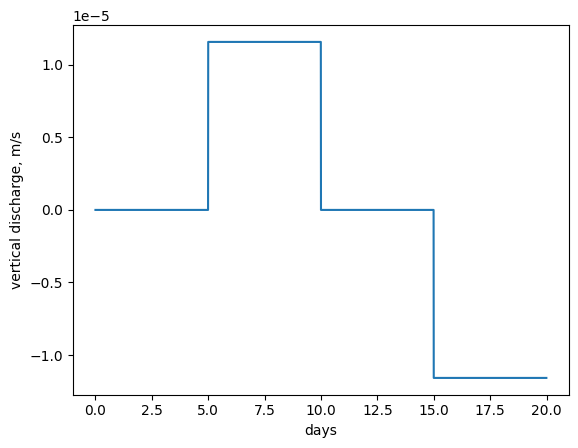

In [214]:
plt.plot(df_BC['days'], df_BC['q'])
plt.xlabel('days')
plt.ylabel('vertical discharge, m/s')
plt.show()

# Transformation of Specific Discharge to Head Difference Using Darcy's Law

To transform the specific discharge ( $q$) (in m/s) into a head difference ( $Delta h $) using Darcy's Law, follow these steps:

## Darcy's Law

Darcy's Law is given by:

$$
q = K \cdot \frac{\Delta h}{L}
$$
Where:
- $ q$ = specific discharge (m/s)
- $ k $ = hydraulic conductivity or permeability (m/s)
- $ L $ = length of the flow path (m)
- $\Delta h$= head difference (m)

### Rearranging Darcy's Law

To solve for the head difference  $\Delta h $, we rearrange the equation:

$$
\Delta h = \frac{q \cdot L}{K}
$$



### Consideration of Elevation Difference


$$
\Delta h = \frac{q \cdot (z_{\text{top}} - z_{\text{bottom}})}{K}
$$



$$
K = \frac{k \rho \cdot g}{\mu}
$$

Where:
- **Intrinsic Permeability** = intrinsic permeability [m²]
- $ \mu $ = viscosity [Pa·s]
- $\rho $ = density [kg/m³]
- $ g $ = gravitational acceleration [m/s²]


This simplifies to:

$$
\Delta h = \frac{q \cdot (z_{\text{top}} - z_{\text{bottom}}) \cdot \mu}{k \cdot \rho \cdot g}
$$


In [215]:
K=10**REF_k*rho*g/mu
print('K=',K)

K= 3.10219438462518e-07


In [216]:
# Calculate deltaP and add to the DataFrame
df_BC['deltaP'] = df_BC['q'] * az * mu / (rho * g * 10**REF_k)

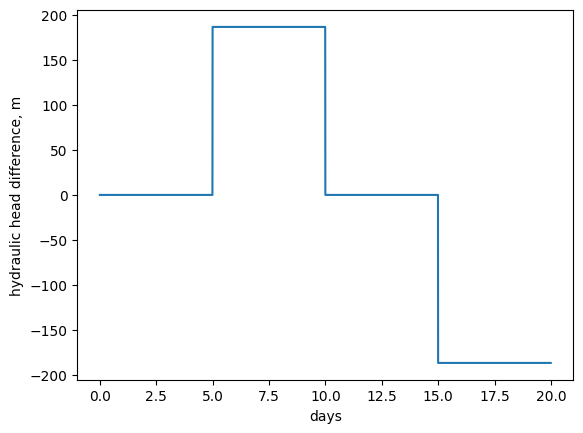

In [217]:
plt.plot(df_BC['days'], df_BC['deltaP'])
plt.xlabel('days')
plt.ylabel('hydraulic head difference, m')
plt.show()

In [218]:
# Pre-calculate constants
two_pi = 2 * np.pi

# Linear temperature increase over time (0.3 degrees per day)
deg_per_day = 0.3



# Calculate the top boundary temperature
df_BC['T_top'] = (5 * np.sin(two_pi * df_BC['times'] / seconds_per_day)  # Daily fluctuation
                  + deg_per_day * df_BC['days']  # Linear increase per day
                  + 3 * np.sin(two_pi * df_BC['times'] / seconds_per_week)  # Weekly fluctuation
                  + 17)  # Base temperature offset

# Set the bottom boundary temperature to a constant value (10 degrees)
df_BC['T_bottom'] = 10 * np.ones_like(df_BC['times'])

# Display the first few rows to check the results (optional)
print(df_BC.head())


   times      days    q  deltaP      T_top  T_bottom
0      0  0.000000  0.0     0.0  17.000000        10
1    600  0.006944  0.0     0.0  17.238880        10
2   1200  0.013889  0.0     0.0  17.477344        10
3   1800  0.020833  0.0     0.0  17.714978        10
4   2400  0.027778  0.0     0.0  17.951366        10


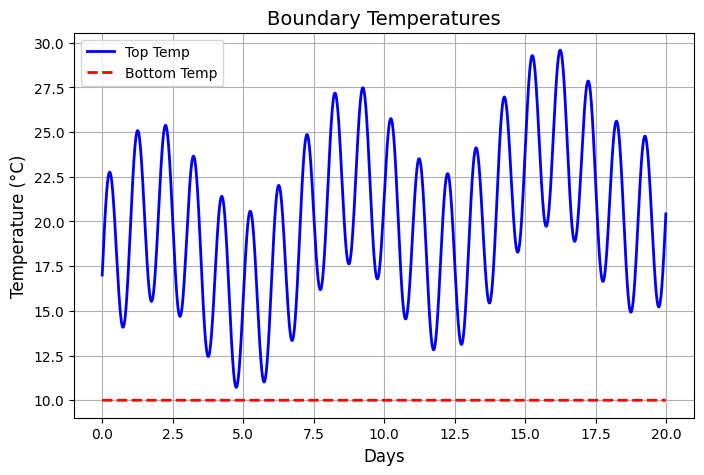

In [219]:
# Plot only the first 1000 points for quicker visualization
plt.figure(figsize=(8, 5))
plt.plot(df_BC['days'], df_BC['T_top'], label='Top Temp', color='b', lw=2)
plt.plot(df_BC['days'], df_BC['T_bottom'], label='Bottom Temp', color='r', ls='--', lw=2)

plt.xlabel('Days', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Boundary Temperatures', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

plt.show()

In [220]:
date_simul_bg=pd.to_datetime("2022/04/21 14:00:00")

# Create the obs_temp DataFrame
obs_temp = pd.DataFrame({
    'dates': date_simul_bg + pd.to_timedelta(df_BC['times'], unit='s'),
    'deltaP': df_BC['deltaP'],
    'T_top': df_BC['T_top'],
    'T_bottom': df_BC['T_bottom']
})
# Display the obs_temp DataFrame
print(obs_temp)

                   dates      deltaP      T_top  T_bottom
0    2022-04-21 14:00:00    0.000000  17.000000        10
1    2022-04-21 14:10:00    0.000000  17.238880        10
2    2022-04-21 14:20:00    0.000000  17.477344        10
3    2022-04-21 14:30:00    0.000000  17.714978        10
4    2022-04-21 14:40:00    0.000000  17.951366        10
...                  ...         ...        ...       ...
2875 2022-05-11 13:10:00 -186.546564  19.504743        10
2876 2022-05-11 13:20:00 -186.546564  19.732028        10
2877 2022-05-11 13:30:00 -186.546564  19.961059        10
2878 2022-05-11 13:40:00 -186.546564  20.191425        10
2879 2022-05-11 13:50:00 -186.546564  20.422712        10

[2880 rows x 4 columns]


## Initial temperatures
An initial state is also required to solve for temperatures at later times. Let's make the simplifying assumption that temperatures vary linearly from top to bottom at time $t=0$.

In [221]:
z_obs=[-5]
initial_conditions(obs_temp, z_top, z_bottom, dz, z_obs)

# Boundary conditions

In [222]:
boundary_conditions(obs_temp)

In [207]:
generate_zone_parameters(z_bottom, dz, nb_zone, alt_thk, REF_k, REF_n, REF_l, REF_r, REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None)

Empty DataFrame
Columns: [id, x, z, zone]
Index: []


# run simulation

In [170]:
sim_temp=run_direct_model(date_simul_bg,z_bottom, dz, nb_zone, alt_thk, REF_k, REF_n, REF_l, REF_r, REF_k2=None, REF_n2=None, REF_l2=None, REF_r2=None) 

At line 1415 of file ../../../src/ginette_V2.f90 (unit = 32, file = 'E_zone.dat')
Fortran runtime error: End of file

Error termination. Backtrace:
#0  0x7c3203023960 in ???
#1  0x7c32030244d9 in ???
#2  0x7c320302510f in ???
#3  0x7c320327817b in ???
#4  0x7c3203271684 in ???
#5  0x7c32032722aa in ???
#6  0x595248d98e02 in ???
#7  0x595248dc0bd5 in ???
#8  0x7c3202c29d8f in __libc_start_call_main
	at ../sysdeps/nptl/libc_start_call_main.h:58
#9  0x7c3202c29e3f in __libc_start_main_impl
	at ../csu/libc-start.c:392
#10  0x595248d5f264 in ???
#11  0xffffffffffffffff in ???
